In [1]:
# changing core directory
import os, sys
dir2 = os.path.abspath('')
dir1 = os.path.dirname(dir2)
if not dir1 in sys.path:
    sys.path.append(dir1)
os.chdir('../..')

In [2]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
os.environ["OMP_NUM_THREADS"] = "4"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ["KAGGLE_USERNAME"] = "recsysaccelerate"
os.environ["KAGGLE_KEY"] = "6363e91b656fea576c39e4f55dcc1d00"

In [3]:
from replay.preprocessing.filters import MinCountFilter, NumInteractionsFilter
from replay.splitters import TimeSplitter
from replay.utils import get_spark_session
from replay.data import (
    FeatureHint,
    FeatureInfo,
    FeatureSchema,
    FeatureSource,
    FeatureType,
    Dataset,
)
from replay.data.nn import (
    SequenceTokenizer,
    SequentialDataset,
    TensorFeatureSource,
    TensorSchema,
    TensorFeatureInfo
)

import pandas as pd

/opt/miniconda3/envs/replay/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
import random
import numpy as np

SEED = 42

np.random.seed(SEED)
random.seed(SEED)

## Prepare data

In [5]:
from rs_datasets import MovieLens

In [6]:
movielens = MovieLens("20m")
interactions = movielens.ratings

In [7]:
interactions['rating'].describe()

count    2.000026e+07
mean     3.525529e+00
std      1.051989e+00
min      5.000000e-01
25%      3.000000e+00
50%      3.500000e+00
75%      4.000000e+00
max      5.000000e+00
Name: rating, dtype: float64

In [8]:
print(f"Number of unique users: {interactions.user_id.nunique()}")
print(f"Number of unique items: {interactions.item_id.nunique()}")

Number of unique users: 138493
Number of unique items: 26744


In [9]:
pd.to_datetime(interactions['timestamp'], unit='s').describe()

count                         20000263
mean     2004-11-20 02:32:01.677113984
min                1995-01-09 11:46:44
25%                2000-08-20 18:55:45
50%                2004-12-20 15:18:06
75%         2008-11-02 16:11:57.500000
max                2015-03-31 06:40:02
Name: timestamp, dtype: object

In [10]:
pd.to_datetime(interactions['timestamp'], unit='s')

0          2005-04-02 23:53:47
1          2005-04-02 23:31:16
2          2005-04-02 23:33:39
3          2005-04-02 23:32:07
4          2005-04-02 23:29:40
                   ...        
20000258   2009-11-13 15:42:00
20000259   2009-12-03 18:31:48
20000260   2009-12-07 18:10:57
20000261   2009-11-13 15:42:24
20000262   2009-10-17 20:25:36
Name: timestamp, Length: 20000263, dtype: datetime64[ns]

In [11]:
interactions.head()

,user_id,item_id,rating,timestamp
0,1,2,3.5,1112486027
1,1,29,3.5,1112484676
2,1,32,3.5,1112484819
3,1,47,3.5,1112484727
4,1,50,3.5,1112484580


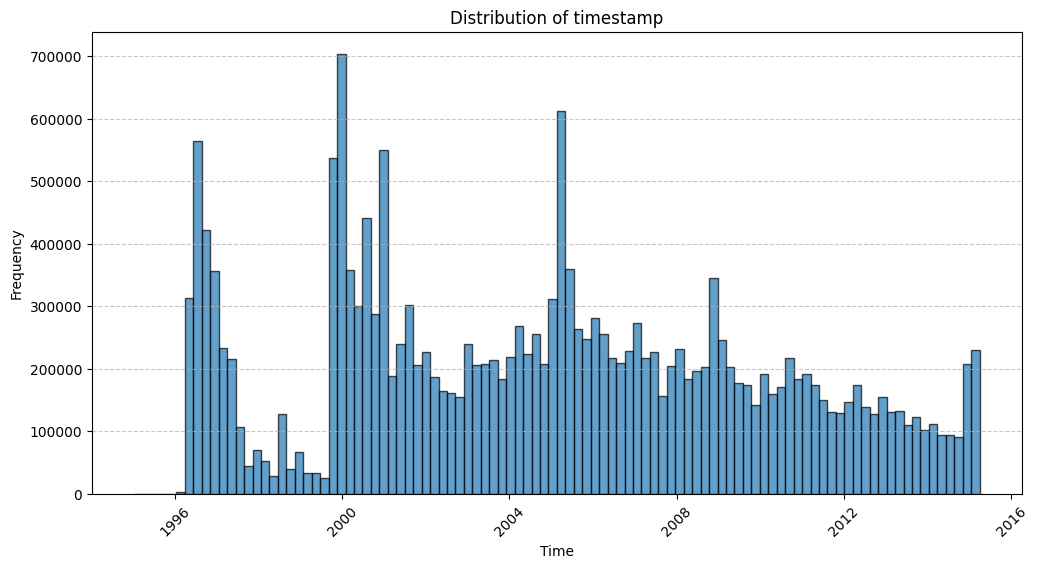

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def plot_timestamp_distribution(df: pd.DataFrame, timestamp_col: str = 'timestamp', unit: str = 's', bins: int = 100):
    df = df.copy()
    df[timestamp_col] = pd.to_datetime(df[timestamp_col], unit=unit)
    df = df.sort_values(timestamp_col)
    
    plt.figure(figsize=(12, 6))
    plt.hist(df[timestamp_col], bins=bins, edgecolor='black', alpha=0.7)
    plt.xlabel('Time')
    plt.ylabel('Frequency')
    plt.title(f'Distribution of {timestamp_col}')
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

plot_timestamp_distribution(interactions)


In [13]:
# Фильтруем данные по минимальному рейтингу
interactions = interactions[
                interactions['rating']
                > 3
            ]

In [14]:
def filter_data(interactions: pd.DataFrame):
    """Filters raw data based on minimum interaction counts."""

    def log_min_counts(data: pd.DataFrame, message_prefix: str):
        user_min = data.groupby("user_id").size().min()
        item_min = data.groupby("item_id").size().min()
        print(
            f"{message_prefix} - Min items per user: {user_min}, Min users per item: {item_min}"
        )

    log_min_counts(interactions, "Before filtering")

    interactions = MinCountFilter(
        num_entries=5,
        groupby_column="item_id",
    ).transform(interactions)

    interactions = MinCountFilter(
        num_entries=3,
        groupby_column="user_id",
    ).transform(interactions)

    log_min_counts(interactions, "After filtering")

    return interactions

interactions = filter_data(interactions)

Before filtering - Min items per user: 1, Min users per item: 1
After filtering - Min items per user: 3, Min users per item: 5


In [15]:
print(interactions.shape)
print(pd.to_datetime(interactions.timestamp.min(), unit='s'))
print(pd.to_datetime(interactions.timestamp.max(), unit='s'))
density = (len(interactions) / (interactions['user_id'].nunique() * interactions['item_id'].nunique())) * 100
print(f"Interaction Density: {density:.2f}%")
mean_seq_len = interactions.groupby('user_id').size().mean()
print(f"Mean Sequence Length: {mean_seq_len:.2f}")

(12180742, 4)
1995-01-09 11:46:44
2015-03-31 06:40:02
Interaction Density: 0.57%
Mean Sequence Length: 88.22


In [16]:
print(f"Number of unique users: {interactions.user_id.nunique()}")
print(f"Number of unique items: {interactions.item_id.nunique()}")

Number of unique users: 138078
Number of unique items: 15405


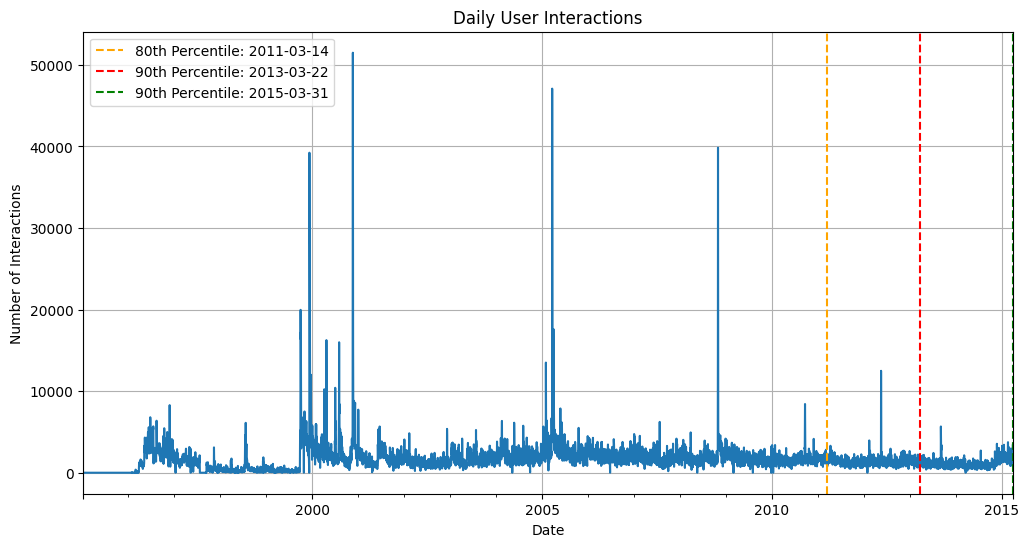

In [17]:
temp_interactions = interactions.copy()
temp_interactions['timestamp'] = pd.to_datetime(temp_interactions['timestamp'], unit='s')
daily_interactions = temp_interactions.resample('D', on='timestamp').size()
percentile_80_date = daily_interactions.index[int(0.8 * len(daily_interactions)) - 1]
percentile_90_date = daily_interactions.index[int(0.9 * len(daily_interactions)) - 1]
percentile_100_date = daily_interactions.index[int(1 * len(daily_interactions)) - 1]
plt.figure(figsize=(12, 6))
daily_interactions.plot()
plt.title('Daily User Interactions')
plt.xlabel('Date')
plt.ylabel('Number of Interactions')
plt.axvline(x=percentile_80_date, color='orange', linestyle='--', label=f'80th Percentile: {percentile_80_date.date()}')
plt.axvline(x=percentile_90_date, color='red', linestyle='--', label=f'90th Percentile: {percentile_90_date.date()}')
plt.axvline(x=percentile_100_date, color='green', linestyle='--', label=f'90th Percentile: {percentile_100_date.date()}')
plt.legend()
plt.grid(True)
plt.show()

In [18]:
def split_data(interactions):
    """Split data for training, validation, and testing."""
    splitter = TimeSplitter(
        time_threshold=0.1,
        drop_cold_users=True,
        drop_cold_items=True,
        item_column="item_id",
        query_column="user_id",
        timestamp_column="timestamp",
    )

    test_events, test_gt = splitter.split(interactions)
    validation_events, validation_gt = splitter.split(test_events)
    train_events = validation_events

    test_gt = test_gt[
        test_gt["item_id"].isin(train_events["item_id"])
    ]
    test_gt = test_gt[
        test_gt["user_id"].isin(train_events["user_id"])
    ]

    print(
        f"Distribution of seq_len in validation:\n{validation_gt.groupby('user_id')['item_id'].agg('count').describe()}."
    )
    print(
        f"Distribution of seq_len in test:\n{test_gt.groupby('user_id')['item_id'].agg('count').describe()}."
    )
    max_test_interactions = 200

    if max_test_interactions is not None:

        validation_gt = NumInteractionsFilter(
            num_interactions=max_test_interactions,
            first=True,
            query_column='user_id',
            item_column='item_id',
            timestamp_column='timestamp',
        ).transform(validation_gt)
        print(
            f"Distribution of seq_len in validation  after filtering:\n{validation_gt.groupby('user_id')['item_id'].agg('count').describe()}."
        )

        test_gt = NumInteractionsFilter(
            num_interactions=max_test_interactions,
            first=True,
            query_column='user_id',
            item_column='item_id',
            timestamp_column='timestamp',
        ).transform(test_gt)
        print(
            f"Distribution of seq_len in test after filtering:\n{test_gt.groupby('user_id')['item_id'].agg('count').describe()}."
        )
    else:
        print("max_num_test_interactions is null. Skipping filtration.")

    return {
        "train": train_events,
        "validation": validation_events,
        "validation_gt": validation_gt,
        "test": test_events,
        "test_gt": test_gt,
    }

splits = split_data(interactions)

Distribution of seq_len in validation:
count    4736.000000
mean       38.871833
std        61.860229
min         1.000000
25%         7.000000
50%        20.000000
75%        48.000000
max      1454.000000
Name: item_id, dtype: float64.
Distribution of seq_len in test:
count    3047.000000
mean       33.013456
std        51.225713
min         1.000000
25%         6.000000
50%        16.000000
75%        38.000000
max       611.000000
Name: item_id, dtype: float64.
Distribution of seq_len in validation  after filtering:
count    4736.000000
mean       36.135557
std        43.611516
min         1.000000
25%         7.000000
50%        20.000000
75%        48.000000
max       200.000000
Name: item_id, dtype: float64.
Distribution of seq_len in test after filtering:
count    3047.000000
mean       31.191992
std        41.190622
min         1.000000
25%         6.000000
50%        16.000000
75%        38.000000
max       200.000000
Name: item_id, dtype: float64.


In [19]:
def prepare_feature_schema(is_ground_truth: bool) -> FeatureSchema:
    """Prepare the feature schema based on whether ground truth is needed."""
    base_features = FeatureSchema(
        [
            FeatureInfo(
                column="user_id",
                feature_hint=FeatureHint.QUERY_ID,
                feature_type=FeatureType.CATEGORICAL,
            ),
            FeatureInfo(
                column="item_id",
                feature_hint=FeatureHint.ITEM_ID,
                feature_type=FeatureType.CATEGORICAL,
            ),
        ]
    )
    if is_ground_truth:
        return base_features

    return base_features + FeatureSchema(
        [
            FeatureInfo(
                column="timestamp",
                feature_type=FeatureType.NUMERICAL,
                feature_hint=FeatureHint.TIMESTAMP,
            ),
        ]
    )

def prepare_datasets(
        train_events,
        validation_events,
        validation_gt,
        test_events,
        test_gt,
    ):
    """Prepare Dataset objects for training, validation, and testing."""
    train_dataset = Dataset(
        feature_schema=prepare_feature_schema(is_ground_truth=False),
        interactions=train_events,
        check_consistency=True,
        categorical_encoded=False,
    )
    validation_dataset = Dataset(
        feature_schema=prepare_feature_schema(is_ground_truth=False),
        interactions=validation_events,
        check_consistency=True,
        categorical_encoded=False,
    )
    validation_gt_dataset = Dataset(
        feature_schema=prepare_feature_schema(is_ground_truth=True),
        interactions=validation_gt,
        check_consistency=True,
        categorical_encoded=False,
    )
    test_dataset = Dataset(
        feature_schema=prepare_feature_schema(is_ground_truth=False),
        interactions=test_events,
        check_consistency=True,
        categorical_encoded=False,
    )
    test_gt_dataset = Dataset(
        feature_schema=prepare_feature_schema(is_ground_truth=True),
        interactions=test_gt,
        check_consistency=True,
        categorical_encoded=False,
    )

    return (
        train_dataset,
        validation_dataset,
        validation_gt_dataset,
        test_dataset,
        test_gt_dataset,
    )

train_dataset, val_dataset, val_gt_dataset, test_dataset, test_gt_dataset = (
    prepare_datasets(*splits.values())
)
item_count = train_dataset.item_count

In [20]:
tensor_schema = TensorSchema(
    TensorFeatureInfo(
        name="item_id_seq",
        is_seq=True,
        feature_type=FeatureType.CATEGORICAL,
        feature_sources=[
            TensorFeatureSource(
                FeatureSource.INTERACTIONS,
                "item_id",
            )
        ],
        feature_hint=FeatureHint.ITEM_ID,
        embedding_dim=128,
    )
)

def initialize_tokenizer(train_dataset: Dataset, tensor_schema) -> SequenceTokenizer:
    """Initialize and fit the SequenceTokenizer."""
    tokenizer = SequenceTokenizer(
        tensor_schema, allow_collect_to_master=True, handle_unknown_rule="drop"
    )
    tokenizer.fit(train_dataset)
    return tokenizer

def prepare_sequential_validation(
        validation_dataset: Dataset, validation_gt: Dataset, tokenizer
    ):
    """Prepare sequential datasets for validation."""
    seq_validation_dataset = tokenizer.transform(validation_dataset)
    seq_validation_gt = tokenizer.transform(
        validation_gt, [tensor_schema.item_id_feature_name]
    )

    return SequentialDataset.keep_common_query_ids(
        seq_validation_dataset, seq_validation_gt
    )

def prepare_sequential_test(
    test_dataset: Dataset, test_gt: Dataset, tokenizer
) -> SequentialDataset:
    """Prepare sequential dataset for testing."""
    test_query_ids = test_gt.query_ids
    test_query_ids_np = tokenizer.query_id_encoder.transform(test_query_ids)[
        "user_id"
    ].values
    return tokenizer.transform(test_dataset).filter_by_query_id(
        test_query_ids_np
    )
    
def prepare_seq_datasets(
    train_dataset: Dataset,
    validation_dataset: Dataset,
    validation_gt: Dataset,
    test_dataset: Dataset,
    test_gt: Dataset,
):
    """Prepare SequentialDataset objects for training, validation, and testing."""
    tokenizer = initialize_tokenizer(train_dataset, tensor_schema)

    seq_train_dataset = tokenizer.transform(train_dataset)
    seq_validation_dataset, seq_validation_gt = prepare_sequential_validation(
        validation_dataset, validation_gt, tokenizer
    )
    seq_test_dataset = prepare_sequential_test(test_dataset, test_gt, tokenizer)

    return (
        seq_train_dataset,
        seq_validation_dataset,
        seq_validation_gt,
        seq_test_dataset,
    )

(
    seq_train_dataset,
    seq_validation_dataset,
    seq_validation_gt,
    seq_test_dataset,
    ) = prepare_seq_datasets(train_dataset, val_dataset, val_gt_dataset, test_dataset, test_gt_dataset)

In [21]:
# Valid_dataset 
exploded_df = seq_validation_dataset._sequences.explode(seq_validation_dataset._item_id_column)
unique_item_ids = exploded_df[seq_validation_dataset._item_id_column].unique()
unique_query_ids = seq_validation_dataset._sequences.index.unique()

print(f"Number of unique item_ids: {len(unique_item_ids)}")
print(f"Number of unique query_ids: {len(unique_query_ids)}")

sequence_lengths = seq_validation_dataset._sequences[seq_validation_dataset._item_id_column].apply(len)
sequence_lengths.describe()

Number of unique item_ids: 12135
Number of unique query_ids: 4736


count    4736.000000
mean      282.357475
std       285.286824
min         1.000000
25%       101.000000
50%       202.000000
75%       373.000000
max      3750.000000
Name: item_id_seq, dtype: float64

In [22]:
# Valid_gt 
exploded_df = seq_validation_gt._sequences.explode(seq_validation_gt._item_id_column)
unique_item_ids = exploded_df[seq_validation_gt._item_id_column].unique()
unique_query_ids = seq_validation_gt._sequences.index.unique()

print(f"Number of unique item_ids: {len(unique_item_ids)}")
print(f"Number of unique query_ids: {len(unique_query_ids)}")

sequence_lengths = seq_validation_gt._sequences[seq_validation_gt._item_id_column].apply(len)
print(sequence_lengths.describe())
print(splits['validation_gt'].shape)

Number of unique item_ids: 8909
Number of unique query_ids: 4736
count    4736.000000
mean       36.135557
std        43.611516
min         1.000000
25%         7.000000
50%        20.000000
75%        48.000000
max       200.000000
Name: item_id_seq, dtype: float64
(171138, 4)


In [23]:
# Test_dataset 
exploded_df = seq_test_dataset._sequences.explode(seq_test_dataset._item_id_column)
unique_item_ids = exploded_df[seq_test_dataset._item_id_column].unique()
unique_query_ids = seq_test_dataset._sequences.index.unique()

print(f"Number of unique item_ids: {len(unique_item_ids)}")
print(f"Number of unique query_ids: {len(unique_query_ids)}")

sequence_lengths = seq_test_dataset._sequences[seq_test_dataset._item_id_column].apply(len)
sequence_lengths.describe()

Number of unique item_ids: 12091
Number of unique query_ids: 3047


count    3047.000000
mean      355.223827
std       316.084767
min         1.000000
25%       151.000000
50%       273.000000
75%       463.000000
max      3821.000000
Name: item_id_seq, dtype: float64

In [24]:
# Test_gt
print(f"Number of unique item_ids: {splits['test_gt'].item_id.nunique()}")
print(f"Number of unique query_ids: {splits['test_gt'].user_id.nunique()}")
print(splits['test_gt'].groupby('user_id')['item_id'].agg('count').describe())
print(splits['test_gt'].shape)

Number of unique item_ids: 7885
Number of unique query_ids: 3047
count    3047.000000
mean       31.191992
std        41.190622
min         1.000000
25%         6.000000
50%        16.000000
75%        38.000000
max       200.000000
Name: item_id, dtype: float64
(95042, 4)


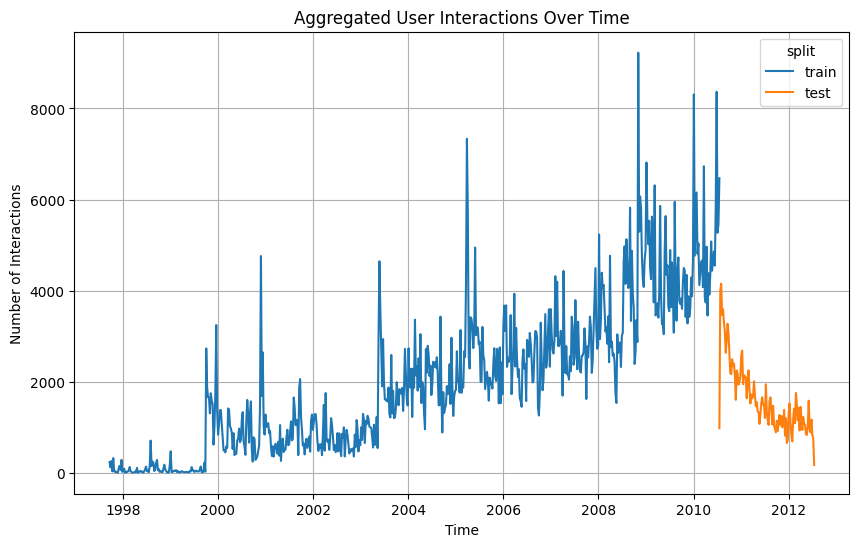

In [25]:
def plot_aggregated_interactions(train, test, time_unit='W'):
    train = train.copy()
    test = test.copy()
    train['timestamp'] = pd.to_datetime(train['timestamp'], unit='s')
    test['timestamp'] = pd.to_datetime(test['timestamp'], unit='s')

    train_agg = train.resample(time_unit, on='timestamp').size().reset_index(name='count')
    test_agg = test.resample(time_unit, on='timestamp').size().reset_index(name='count')

    train_agg['split'] = 'train'
    test_agg['split'] = 'test'

    combined_agg = pd.concat([train_agg, test_agg])

    plt.figure(figsize=(10, 6))
    sns.lineplot(data=combined_agg, x='timestamp', y='count', hue='split')
    plt.title('Aggregated User Interactions Over Time')
    plt.xlabel('Time')
    plt.ylabel('Number of Interactions')
    plt.grid(True)
    plt.show()

val = splits['validation'][splits['validation'].user_id.isin(splits['validation_gt'].user_id.unique())]
val_gt = splits['validation_gt']
plot_aggregated_interactions(val, val_gt)

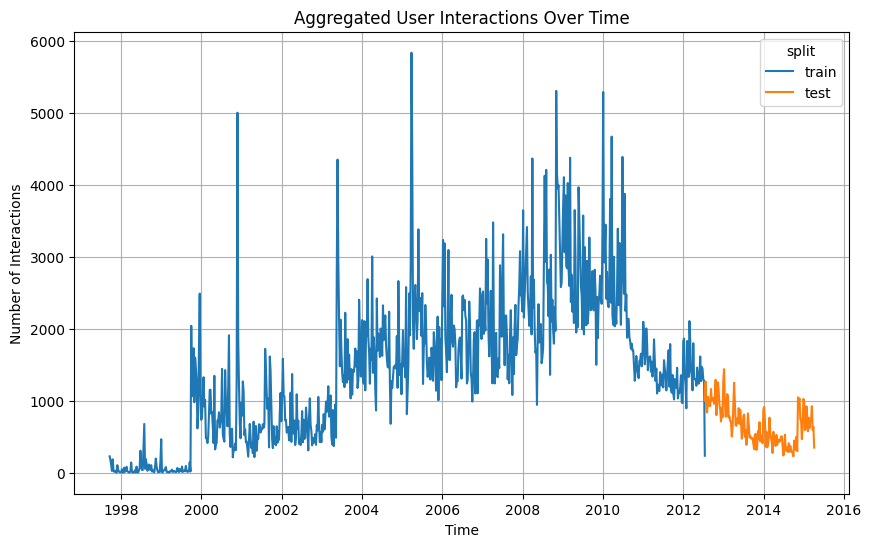

In [26]:
test = splits['test'][splits['test'].user_id.isin(splits['test_gt'].user_id.unique())]
test_gt = splits['test_gt']
plot_aggregated_interactions(test, test_gt)

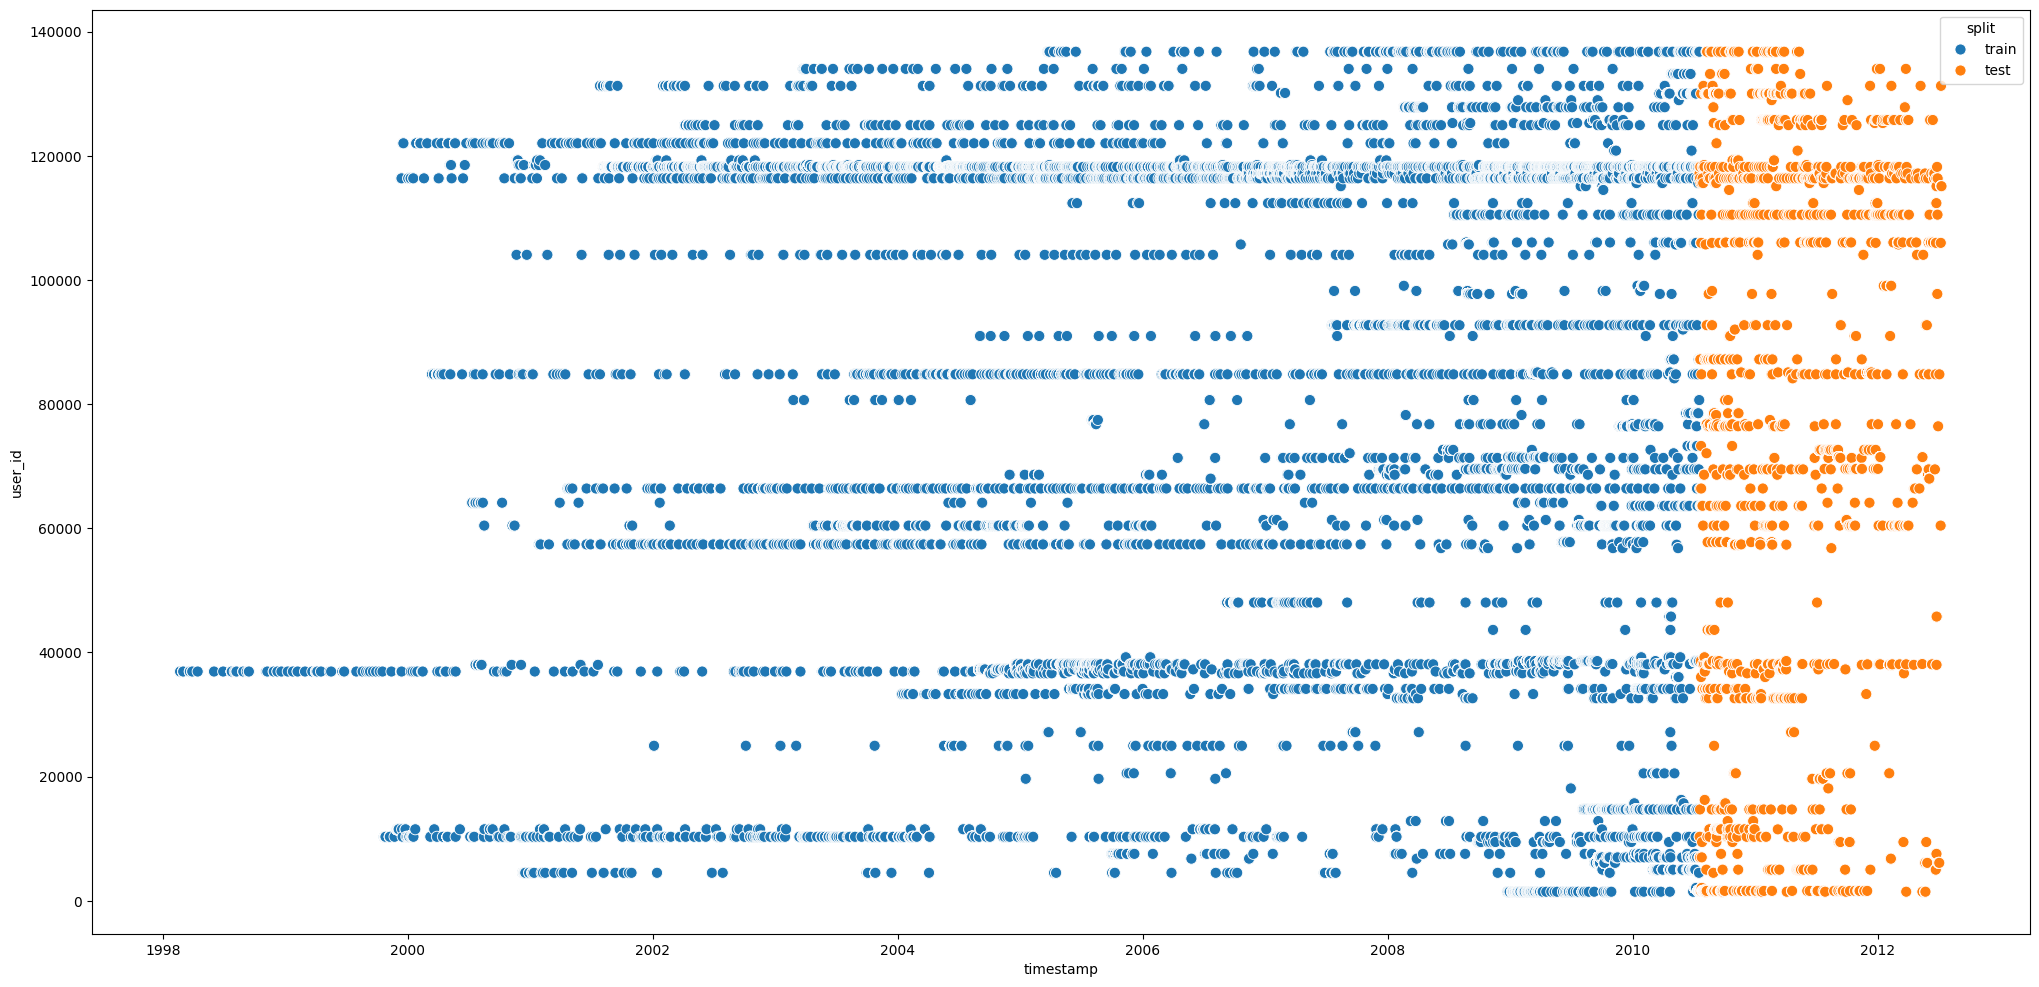

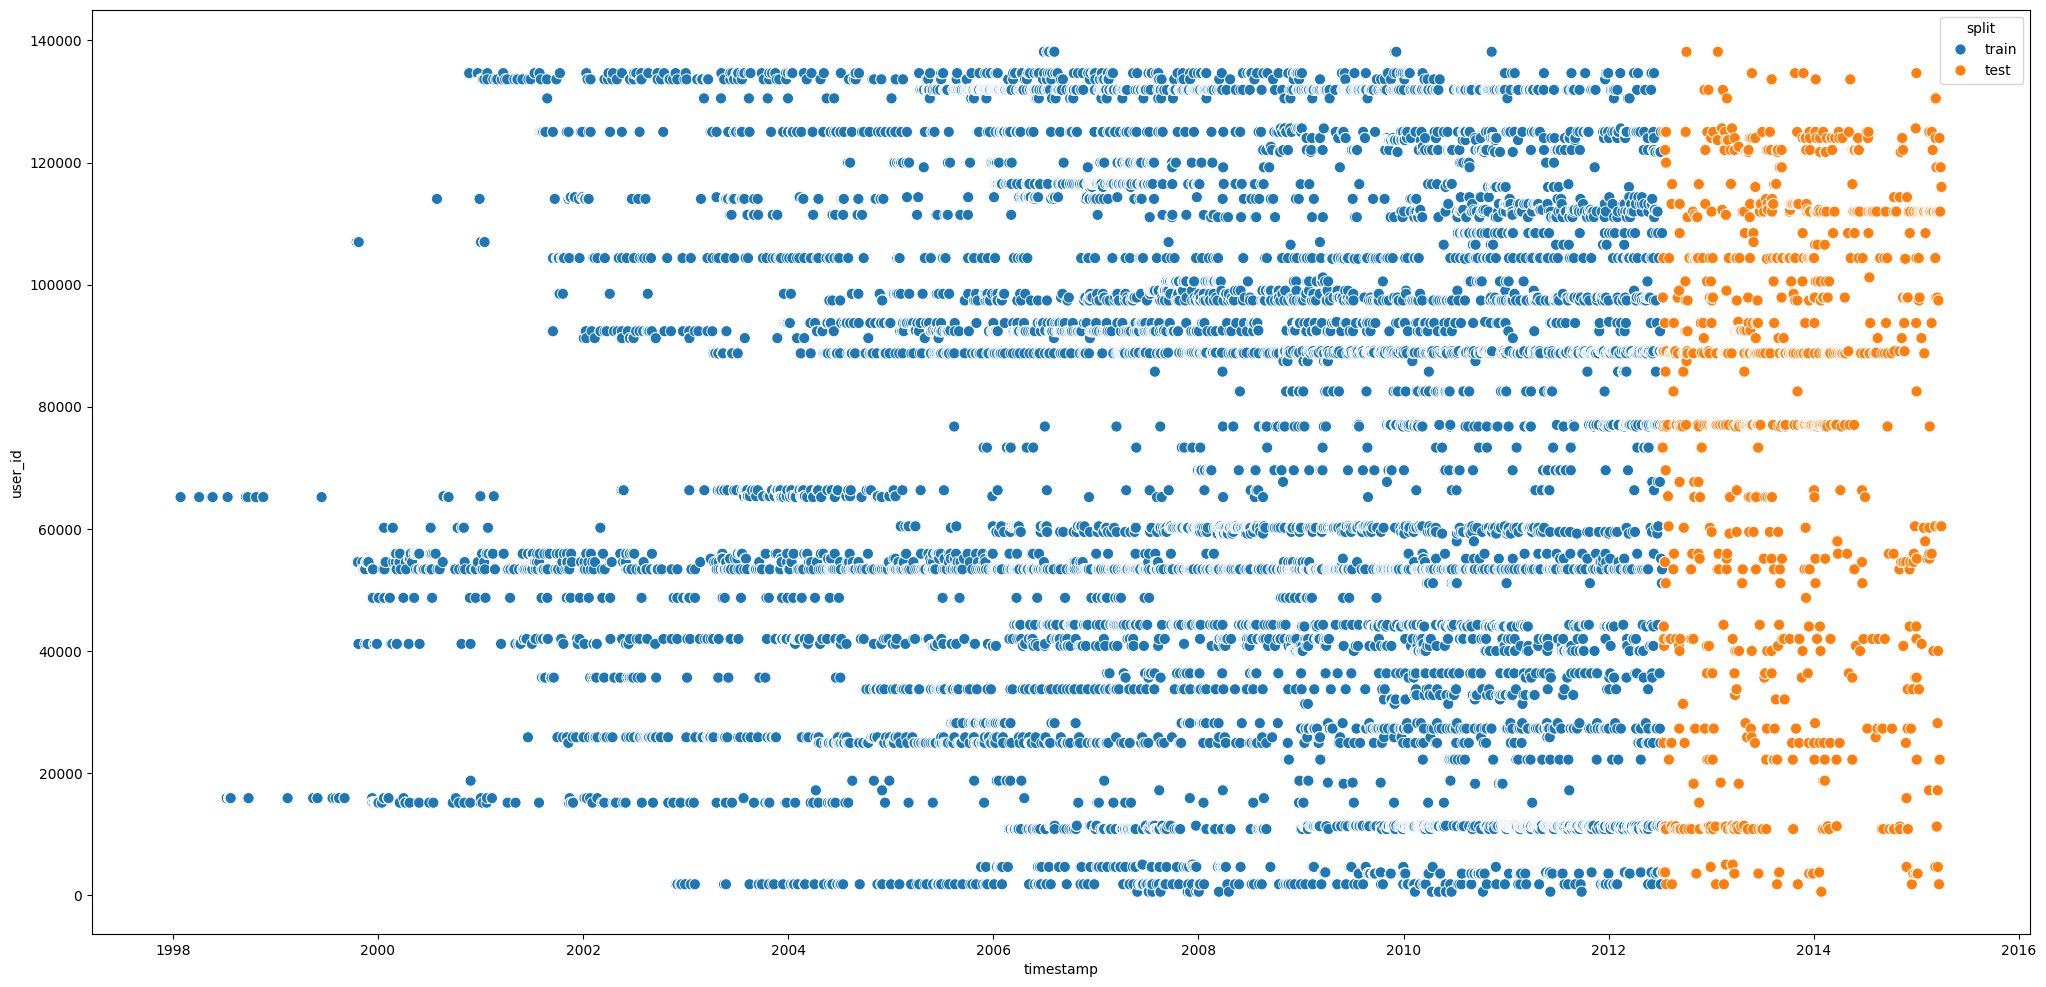

In [27]:
def show_train_test_sampled(train, test, sample_size=100):
    train = train.copy()
    test = test.copy()
    train['timestamp'] = pd.to_datetime(train['timestamp'], unit='s')
    test['timestamp'] = pd.to_datetime(test['timestamp'], unit='s')
    train['split'] = 'train'
    test['split'] = 'test'
    combined = pd.concat([train, test])
    sampled_user_ids = np.random.choice(combined['user_id'].unique(), size=sample_size, replace=False)

    sampled_data = combined[combined['user_id'].isin(sampled_user_ids)]
    plt.figure(figsize=(25, 12))
    sns.scatterplot(data=sampled_data, x='timestamp', y='user_id', hue='split', s=64)
    plt.autoscale(enable=True, axis='x')
    plt.grid(False)
    plt.show()


show_train_test_sampled(val, val_gt)
show_train_test_sampled(test, test_gt)

In [28]:
splits['train'][splits['train'].user_id.isin(test_gt.user_id)]

,user_id,item_id,rating,timestamp
11494230,79366,1407,4.0,874357760
11493912,79366,260,5.0,874357917
11493851,79366,36,4.0,874357965
11494051,79366,800,4.0,874357996
11493849,79366,32,4.0,874358033
...,...,...,...,...
2133620,14449,3634,4.0,1279450181
9287806,64191,77330,4.0,1279451375
12160352,83984,40815,4.0,1279451509
12160266,83984,6281,4.0,1279451604


In [29]:
len(set(splits['train'].item_id))

12379

In [30]:
len(set(val_gt.item_id))

8909

In [31]:
len(set(test_gt.item_id)) 

7885

In [32]:
len(set(test_gt.item_id) - set(val_gt.item_id))

921

In [33]:
splits['train'][splits['train'].item_id.isin(set(test_gt.item_id) - set(val_gt.item_id))]

,user_id,item_id,rating,timestamp
14452516,99851,55,4.0,822873600
17935960,124035,40,4.0,823185249
17598936,121731,40,4.0,823514047
8148480,56139,85,5.0,824389197
14467124,99961,40,5.0,825001665
...,...,...,...,...
7709348,53080,2526,4.0,1279419364
7709368,53080,5969,4.0,1279419368
14389472,99427,51304,4.0,1279424324
16907451,116957,26494,3.5,1279440177


In [34]:
len(set(val_gt.item_id) - set(test_gt.item_id))

1945

In [35]:
splits['train'][splits['train'].item_id.isin(set(val_gt.item_id) - set(test_gt.item_id))]

,user_id,item_id,rating,timestamp
15688196,108467,57,4.0,822873600
17935952,124035,26,5.0,823185239
6734026,46380,4,5.0,823255319
17935980,124035,68,4.0,823264415
16464876,113947,20,4.0,823264595
...,...,...,...,...
7709385,53080,52583,4.0,1279440859
18499323,128056,70726,3.5,1279441123
1592667,10759,2331,3.5,1279441901
18499287,128056,48049,3.5,1279441947


In [36]:
test_gt

,user_id,item_id,rating,timestamp
16246557,112415,2145,3.5,1341892590
16461637,113923,65642,4.0,1341898224
15802217,109286,7842,3.5,1341901579
591982,3971,1203,4.5,1341904044
18700445,129498,6870,4.0,1341905267
...,...,...,...,...
10748796,74303,8665,4.0,1427772616
10748726,74303,4776,3.5,1427772655
11495468,79366,45183,3.5,1427773181
17565955,121535,6443,4.0,1427773520


In [37]:
test_gt[test_gt.item_id.isin(val_gt.item_id.unique())]

,user_id,item_id,rating,timestamp
16246557,112415,2145,3.5,1341892590
16461637,113923,65642,4.0,1341898224
15802217,109286,7842,3.5,1341901579
591982,3971,1203,4.5,1341904044
18700445,129498,6870,4.0,1341905267
...,...,...,...,...
10748796,74303,8665,4.0,1427772616
10748726,74303,4776,3.5,1427772655
11495468,79366,45183,3.5,1427773181
17565955,121535,6443,4.0,1427773520
